# Release Note (V.B1: Internal)
In this version, the following problems should be fixed:

- The amount of material transported each time by a truck to be extracted from truck_list.
- Total amount of material should be extracted from input data.
- The input files to be modified.
- The data used in the truck simulation is to be extracted from truck_list.
- Source and destinations should be added and the location to be the same as the geometry of the road network.
- Routing to be added to the simulation.

In [2]:
import networkx as nx  
import shapely.geometry
import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import logging

In [3]:
# Create a data set fro trucks
def process_truck_data():
    # Read the CSV files
    truck_file = 'HaulageOperation_TruckDetails.csv'
    df_tr = pd.read_csv(truck_file)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df_tr.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])
        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Calculate the total number of trucks as an integer
    total_trucks = int(df_tr['Number of Trucks'].sum())
     
    # Create a new data frame from the list
    df_tr_result = pd.DataFrame(truck_list)

    # Read the Shovel_Truck_Allocation.csv file
    allocation_file_path = 'Shovel_Truck_Allocation.csv'
    allocation_df = pd.read_csv(allocation_file_path)

    # Initialize an empty list to store updated allocation rows
    updated_allocation_list = []

    # Iterate through rows of allocation_df
    for allocation_index, allocation_row in allocation_df.iterrows():
        # Repeat each row based on the number of trucks
        for _ in range(allocation_row['Number of Trucks']):
            # Create a new DataFrame row with the same information as the original row
            updated_allocation_row = allocation_row.copy()
            # Append the updated allocation row to the list
            updated_allocation_list.append(updated_allocation_row)

    # Create a new DataFrame from the updated allocation list
    updated_allocation_df = pd.DataFrame(updated_allocation_list)

    # Drop the 'Number of Trucks' column
    updated_allocation_df.drop(columns=['Number of Trucks'], inplace=True)

    # Reset the index of the DataFrame to be incremental
    updated_allocation_df.reset_index(drop=True, inplace=True)
    
    # Export to CSV file
    updated_allocation_df.to_csv('updated_allocation.csv', index=False)
        # Create new 'Source' and 'Destination' columns in df_tr_result
    df_tr_result['Source'] = ''
    df_tr_result['Destination'] = ''
    
    # Copy the data frame to not be changed in the loop
    updated_allocation = updated_allocation_df.copy()

    # Iterate through rows of df_tr_result
    for index, truck_row in df_tr_result.iterrows():
        # Iterate through rows of updated_allocation_df
        for allocation_index, allocation_row in updated_allocation.iterrows():
            # Check if the text in truck_row['Type'] is contained in allocation_row['Truck Type'] (case-insensitive)
            if truck_row['Type'].lower() in allocation_row['Truck Type'].lower():
                # Assign 'Source' and 'Destination' to the corresponding columns
                df_tr_result.at[index, 'Source'] = allocation_row['Source']
                df_tr_result.at[index, 'Destination'] = allocation_row['Destination']
                # Drop the assigned row from updated_allocation_df
                updated_allocation.drop(allocation_index, inplace=True)
                # Break out of the inner loop to avoid re-assigning the same row to multiple trucks
                break
    # Export to CSV file
    df_tr_result.to_csv('truck_list.csv', index=False)
    
    return df_tr_result, updated_allocation_df, total_trucks


In [4]:
def run(total_waste):
    # Call the function to get truck_list and updated_allocation_df
    truck_list, updated_allocation_df, total_trucks = process_truck_data()

    # truck_list, df_result, total_trucks
    
    # create a Site object based on desired mixin classes
    Site = type('Site',
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object based on desired mixin classes
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
         core.ContainerDependentMovable,
         core.Processor,
         core.HasResource,
         core.LoadingFunction,
         core.UnloadingFunction,
         core.Identifiable,
         core.Log,
        ),
        {},
    )
    
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source01 = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
    data_source01 = {"env": my_env,
                     "name": "source01",
                     "geometry": location_source01,
                     "capacity": total_waste,
                     "level": total_waste
                   # "nr_resources": 1
                    }
    source01 = Site(**data_source01)
    
    # prepare input data for dump
    location_dump01 = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
    data_dump01 = {"env": my_env,
                   "name": "dump01",
                   "geometry": location_dump01,
                   "capacity": total_waste,
                   "level": 0
                  }
    dump01 = Site(**data_dump01)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = truck_list[truck_list['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)

        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump01,
            # level=0,
            loading_rate=1,
            unloading_rate=unloading_rate,
            capacity= truck_info['Payload (Ton)'],
            compute_v=lambda x: 10 + 2 * x,
        )

   # Create activity objects
    activities_d_truck = {}
    cond_level = total_waste - (total_trucks * 20)
    
    for i in range(1, total_trucks + 1):
        # requested_resources = {}
        truck = trucks[f"truck{i}"]
        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source01,
                # duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source01,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                # id_="waste",
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump01,
                # duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump01,
                amount=20,
                duration=25,
                # id_="waste",
            )
        ]
        activities_d_truck[f"activities_d_truck{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_d_truck{i}",
                registry=registry,
                sub_processes=d_subprocesses
            )],
            condition_event=[{"type": "container",
                              "concept": dump01,
                              "state": "gt", "level":cond_level}
                             ]
        )
    
    processes=[*activities_d_truck.values()]
    print(processes)
    model.register_processes(processes)
    try: 
        my_env.run()
    except:
        logging.exception('run did not succeed')
        
    return {
        "trucks": trucks,
        "activities_d_truck": activities_d_truck,
        "source01": source01,
        "dump01": dump01,
        "total_trucks": total_trucks,  # Adding total_trucks to the returned dictionary
        "registry": registry,
    }

In [5]:
# Example usage: 
res = run(1000)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source01 = res['source01']
dump01 = res['dump01']
total_trucks = res['total_trucks']  # Extracting total_trucks
registry = res['registry']

[<openclsim.model.while_activity.WhileActivity object at 0x7f96584ab370>, <openclsim.model.while_activity.WhileActivity object at 0x7f96584abf10>, <openclsim.model.while_activity.WhileActivity object at 0x7f9638a182e0>, <openclsim.model.while_activity.WhileActivity object at 0x7f9638a18df0>, <openclsim.model.while_activity.WhileActivity object at 0x7f96584e6880>, <openclsim.model.while_activity.WhileActivity object at 0x7f96584e6b50>, <openclsim.model.while_activity.WhileActivity object at 0x7f962836a0d0>, <openclsim.model.while_activity.WhileActivity object at 0x7f962836a4f0>, <openclsim.model.while_activity.WhileActivity object at 0x7f962836a910>, <openclsim.model.while_activity.WhileActivity object at 0x7f962836ad30>, <openclsim.model.while_activity.WhileActivity object at 0x7f9628372190>, <openclsim.model.while_activity.WhileActivity object at 0x7f96283725b0>, <openclsim.model.while_activity.WhileActivity object at 0x7f96283729d0>, <openclsim.model.while_activity.WhileActivity obje

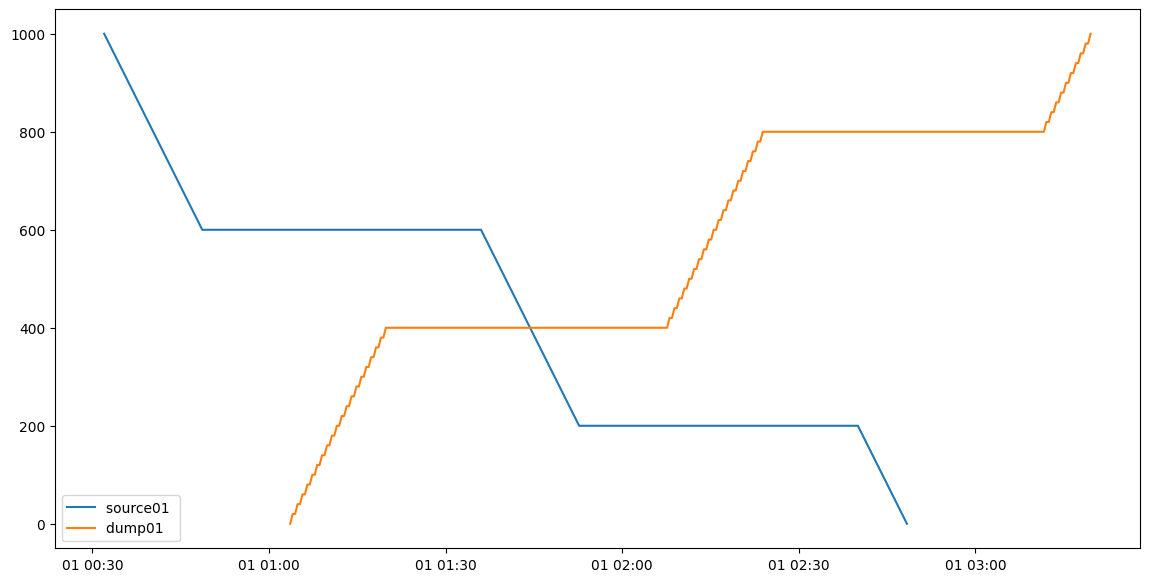

In [6]:
# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source01, dump01])

In [7]:
# Example usage: 
res = run(500)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source01 = res['source01']
dump01 = res['dump01']
total_trucks = res['total_trucks']  # Extracting total_trucks
registry = res['registry']

[<openclsim.model.while_activity.WhileActivity object at 0x7f9bb89ba0d0>, <openclsim.model.while_activity.WhileActivity object at 0x7f9bb89ba4f0>, <openclsim.model.while_activity.WhileActivity object at 0x7f9bb89ba910>, <openclsim.model.while_activity.WhileActivity object at 0x7f9bb89bad30>]


In [8]:
print(source01.container.capacity, source01.container.items)

2 [{'id': 'default', 'capacity': 500, 'level': 20}, {'id': 'default_reservations', 'capacity': 500, 'level': 20}]


In [9]:
print(source01.container.get_level())

20


In [10]:
print(dump01.container.capacity, dump01.container.items)

2 [{'id': 'default', 'capacity': 500, 'level': 480}, {'id': 'default_reservations', 'capacity': 500, 'level': 480}]


In [ ]:
pd.DataFrame(dump01.logbook)

In [33]:
truck1 = trucks['truck1']
# display(plot.get_log_dataframe(truck1))

# plot.get_log_dataframe(get_tree_as_list(truck1))


NameError: name 'get_tree_as_list' is not defined

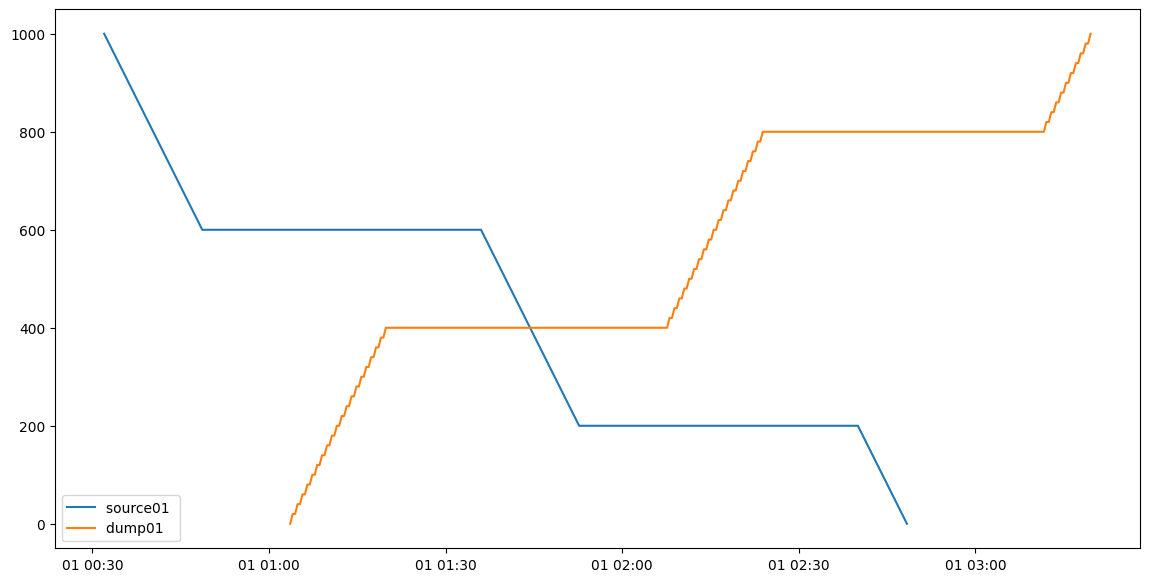

In [34]:
# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source01, dump01])


In [16]:
# Create an empty dictionary to store truck dataframes
truck_dfs = {}

# Iterate over the range from 1 to total_trucks
for i in range(1, total_trucks + 1):
    # Dynamically access truck object using trucks dictionary
    truck_obj = trucks[f"truck{i}"]
    
    # Create DataFrame for truck logbook and store it in the dictionary
    truck_dfs[f"truck{i}_df"] = pd.DataFrame(truck_obj.logbook)




In [19]:
print(truck_dfs["truck2_df"])


                    Timestamp                            ActivityID  \
0  1970-01-01 00:00:00.000000  ab5b08bd-4e6e-4f4d-8cd6-d051767a1dc1   
1  1970-01-01 00:32:00.113018  ab5b08bd-4e6e-4f4d-8cd6-d051767a1dc1   
2  1970-01-01 00:32:50.113018  aa3b1b82-082d-4efb-9545-4afa2d35643f   
3  1970-01-01 00:33:40.113018  aa3b1b82-082d-4efb-9545-4afa2d35643f   
4  1970-01-01 00:33:40.113018  b8ae235e-adac-48cc-a2ae-8b9c98eec7c6   
5  1970-01-01 01:04:26.375536  b8ae235e-adac-48cc-a2ae-8b9c98eec7c6   
6  1970-01-01 01:04:26.375536  7efe9eaa-c93a-494b-be8b-586dc9945f00   
7  1970-01-01 01:04:51.375536  7efe9eaa-c93a-494b-be8b-586dc9945f00   
8  1970-01-01 01:04:51.375536  ab5b08bd-4e6e-4f4d-8cd6-d051767a1dc1   
9  1970-01-01 01:36:51.488555  ab5b08bd-4e6e-4f4d-8cd6-d051767a1dc1   
10 1970-01-01 01:36:51.488555  aa3b1b82-082d-4efb-9545-4afa2d35643f   
11 1970-01-01 01:37:41.488555  aa3b1b82-082d-4efb-9545-4afa2d35643f   
12 1970-01-01 01:37:41.488555  b8ae235e-adac-48cc-a2ae-8b9c98eec7c6   
13 197

In [ ]:
truck1 = trucks['truck1']
pd.DataFrame(truck1.logbook)